In [20]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
print('import finish')

import finish


In [21]:
joint_number = 5

In [22]:
datasets = []
for file_name in list(os.listdir('datasets')):
    dataset = pd.read_table(f'datasets/{file_name}', sep=' ')
    datasets.append(dataset)
    print(dataset.shape)


(51, 16)
(70, 16)
(59, 16)
(44, 16)
(34, 16)
(36, 16)
(91, 16)
(32, 16)
(32, 16)
(45, 16)
(50, 16)
(50, 16)
(83, 16)
(38, 16)
(43, 16)
(47, 16)
(38, 16)
(27, 16)
(35, 16)
(46, 16)
(57, 16)
(35, 16)
(40, 16)
(50, 16)
(57, 16)
(77, 16)
(44, 16)
(38, 16)
(40, 16)
(30, 16)
(31, 16)
(18, 16)
(34, 16)
(39, 16)
(31, 16)
(35, 16)
(28, 16)
(45, 16)


In [23]:
datasets[0]

,time,PosLHipPitch,VelLHipPitch,ForLHipPitch,PosLHipRoll,VelLHipRoll,ForLHipRoll,PosLKnee,VelLKnee,ForLKnee,PosLAnklePitch,VelLAnklePitch,ForLAnklePitch,PosLAnkleRoll,VelLAnkleRoll,ForLAnkleRoll
0,0.540000,0.303936,-0.058696,-0.864765,0.081947,0.041973,3.521635,-1.077866,0.007033,6.824475,0.599608,0.618406,2.383964,0.340019,-0.006825,-0.069354
1,0.542000,0.303853,-0.041590,1.374825,0.082512,0.282418,12.989949,-1.077466,0.199857,-1.350539,0.599958,0.175329,2.248574,0.339141,-0.439053,1.793611
2,0.544000,0.303697,-0.078366,1.374825,0.082915,0.201131,12.989949,-1.076598,0.434106,-1.350539,0.599379,-0.289742,2.248574,0.337672,-0.734711,1.793611
3,0.546000,0.303463,-0.116961,1.374825,0.083190,0.137499,12.989949,-1.075267,0.665733,-1.350539,0.597890,-0.744323,2.248574,0.335670,-1.000805,1.793611
4,0.548000,0.303150,-0.156121,1.374825,0.083361,0.085839,12.989949,-1.073476,0.895512,-1.350539,0.595503,-1.193747,2.248574,0.333156,-1.257108,1.793611
5,0.550000,0.302760,-0.195208,1.374825,0.083446,0.042610,12.989949,-1.071227,1.124575,-1.350539,0.592221,-1.640937,2.248574,0.330130,-1.513113,1.793611
6,0.552000,0.302291,-0.234428,1.374825,0.083458,0.005648,12.989949,-1.068519,1.353698,-1.350539,0.588045,-2.087799,2.248574,0.326585,-1.772754,1.793611
7,0.554000,0.301744,-0.273604,1.374825,0.083405,-0.026550,12.989949,-1.065351,1.584312,-1.350539,0.582973,-2.536002,2.248574,0.322510,-2.037432,1.793611
8,0.556000,0.301117,-0.313316,1.374825,0.083295,-0.054990,12.989949,-1.061717,1.817011,-1.350539,0.577000,-2.986589,2.248574,0.317895,-2.307519,1.793611
9,0.558000,0.300410,-0.353743,1.374825,0.083134,-0.080363,12.989949,-1.057611,2.052810,-1.350539,0.570120,-3.440216,2.248574,0.312729,-2.583075,1.793611


In [24]:
full_datasets = []
for dataset in datasets:
    time = dataset['time']
    col_names_vel = [el for el in datasets[0].columns if el.startswith('Vel')]
    velocities = dataset[col_names_vel]
    diff_v = np.diff(velocities, axis=0)
    diff_t = np.diff(time, axis=0)
    col_names_acc = [el.replace('Vel', 'Acc') for el in col_names_vel]
    acc = pd.DataFrame(np.transpose(np.transpose(diff_v)/diff_t), columns=col_names_acc)
    dataset_with_acc = dataset.join(acc)
    full_datasets.append(dataset_with_acc[:-1])
    print(dataset_with_acc.shape)

full_dataset = pd.concat(full_datasets)
print(full_dataset.shape)


(51, 21)
(70, 21)
(59, 21)
(44, 21)
(34, 21)
(36, 21)
(91, 21)
(32, 21)
(32, 21)
(45, 21)
(50, 21)
(50, 21)
(83, 21)
(38, 21)
(43, 21)
(47, 21)
(38, 21)
(27, 21)
(35, 21)
(46, 21)
(57, 21)
(35, 21)
(40, 21)
(50, 21)
(57, 21)
(77, 21)
(44, 21)
(38, 21)
(40, 21)
(30, 21)
(31, 21)
(18, 21)
(34, 21)
(39, 21)
(31, 21)
(35, 21)
(28, 21)
(45, 21)
(1642, 21)


In [25]:
full_dataset

,time,PosLHipPitch,VelLHipPitch,ForLHipPitch,PosLHipRoll,VelLHipRoll,ForLHipRoll,PosLKnee,VelLKnee,ForLKnee,...,VelLAnklePitch,ForLAnklePitch,PosLAnkleRoll,VelLAnkleRoll,ForLAnkleRoll,AccLHipPitch,AccLHipRoll,AccLKnee,AccLAnklePitch,AccLAnkleRoll
0,0.540000,0.303936,-0.058696,-0.864765,0.081947,0.041973,3.521635,-1.077866,0.007033,6.824475,...,0.618406,2.383964,0.340019,-0.006825,-0.069354,8.553487,120.223802,96.412998,-221.541284,-216.117110
1,0.542000,0.303853,-0.041590,1.374825,0.082512,0.282418,12.989949,-1.077466,0.199857,-1.350539,...,0.175329,2.248574,0.339141,-0.439053,1.793611,-18.388504,-40.643962,117.126147,-232.538602,-147.830780
2,0.544000,0.303697,-0.078366,1.374825,0.082915,0.201131,12.989949,-1.076598,0.434106,-1.350539,...,-0.289742,2.248574,0.337672,-0.734711,1.793611,-19.297502,-31.816661,115.814806,-227.293274,-133.048429
3,0.546000,0.303463,-0.116961,1.374825,0.083190,0.137499,12.989949,-1.075267,0.665733,-1.350539,...,-0.744323,2.248574,0.335670,-1.000805,1.793611,-19.580631,-25.829968,114.890892,-224.715295,-128.153305
4,0.548000,0.303150,-0.156121,1.374825,0.083361,0.085839,12.989949,-1.073476,0.895512,-1.350539,...,-1.193747,2.248574,0.333156,-1.257108,1.793611,-19.543378,-21.614690,114.533260,-223.597663,-128.004232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,5.049999,0.115957,2.456113,-2.392963,-0.005977,0.069294,-11.894687,-0.243982,-8.163150,0.766266,...,10.548654,-0.046611,0.293004,14.710777,-1.727230,-18.649619,7.345009,22.146400,73.778255,68.749165
40,5.051999,0.120794,2.418816,-2.392963,-0.005809,0.083983,-11.894687,-0.260218,-8.118860,0.766266,...,10.696199,-0.046611,0.322698,14.848266,-1.727230,-21.714115,8.173425,32.779685,62.286600,58.487840
41,5.053998,0.125544,2.375391,-2.392963,-0.005608,0.100329,-11.894687,-0.276324,-8.053306,0.766266,...,10.820764,-0.046611,0.352627,14.965233,-1.727230,-24.409752,8.966325,42.735336,51.147830,49.106342
42,5.055998,0.130197,2.326575,-2.392963,-0.005372,0.118260,-11.894687,-0.292258,-7.967841,0.766266,...,10.923052,-0.046611,0.382751,15.063438,-1.727230,-26.796257,9.749449,51.737005,40.487840,40.447783


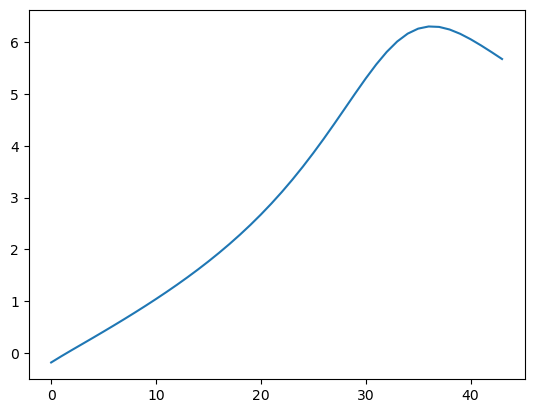

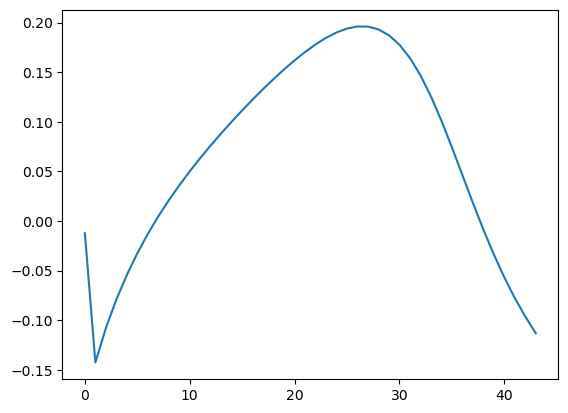

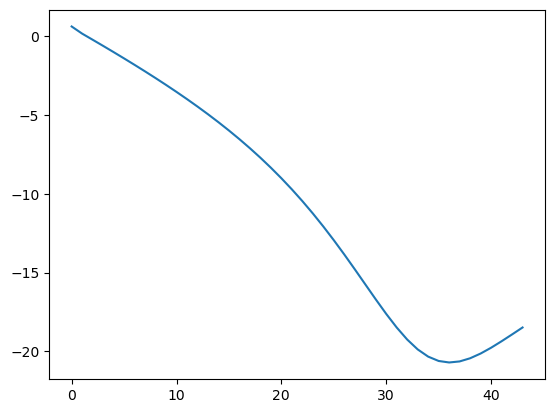

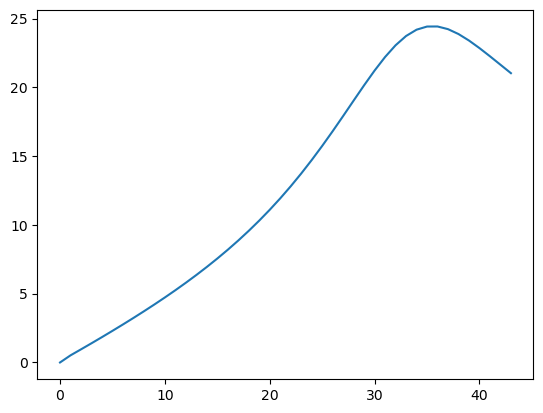

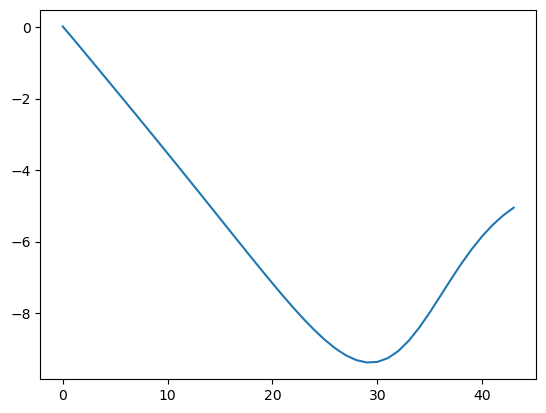

In [81]:
def plot_(name, df, i=0):
    col = [el for el in df.columns if el.startswith(name)]
    val = df[col]
    i = val.iloc[:, i]
    plt.plot(range(len(i)), i)
    plt.show()


# plot_('Pos', full_datasets[8], 3)
# plot_('Vel', full_datasets[0], 1)
# plot_('Acc', full_datasets[2], 0)
# plot_('For', full_datasets[8], 3)
for i in range(5):
    plot_('Vel', full_datasets[9], i)

# data preprocessing

In [28]:
df = full_dataset
print(df.shape)
normalized_dataset = (df-df.min())/(df.max()-df.min())
normalized_dataset['time'] = full_dataset['time']
normalized_dataset

(1642, 21)


,time,PosLHipPitch,VelLHipPitch,ForLHipPitch,PosLHipRoll,VelLHipRoll,ForLHipRoll,PosLKnee,VelLKnee,ForLKnee,...,VelLAnklePitch,ForLAnklePitch,PosLAnkleRoll,VelLAnkleRoll,ForLAnkleRoll,AccLHipPitch,AccLHipRoll,AccLKnee,AccLAnklePitch,AccLAnkleRoll
0,0.540000,0.726453,0.514271,0.328867,0.991181,0.487782,0.647328,0.115366,0.473132,0.902435,...,0.523579,1.000000,0.873718,0.546006,0.460675,0.565293,0.649581,0.497730,0.419203,0.221083
1,0.542000,0.726356,0.515189,0.724380,0.994479,0.565062,1.000000,0.115554,0.476642,0.453852,...,0.515598,0.970970,0.872758,0.536283,0.857532,0.513952,0.418514,0.511698,0.412390,0.279237
2,0.544000,0.726174,0.513215,0.724380,0.996828,0.538936,1.000000,0.115964,0.480906,0.453852,...,0.507221,0.970970,0.871152,0.529633,0.857532,0.512219,0.431194,0.510814,0.415640,0.291826
3,0.546000,0.725901,0.511143,0.724380,0.998434,0.518484,1.000000,0.116591,0.485123,0.453852,...,0.499033,0.970970,0.868965,0.523648,0.857532,0.511680,0.439793,0.510191,0.417237,0.295995
4,0.548000,0.725538,0.509041,0.724380,0.999436,0.501880,1.000000,0.117435,0.489305,0.453852,...,0.490938,0.970970,0.866218,0.517883,0.857532,0.511751,0.445848,0.509949,0.417929,0.296122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,5.049999,0.507566,0.649265,0.058986,0.477756,0.496563,0.073107,0.508413,0.324402,0.570006,...,0.702443,0.478844,0.822345,0.877053,0.107507,0.513454,0.487445,0.447648,0.602162,0.463683
40,5.051999,0.513199,0.647263,0.058986,0.478737,0.501284,0.073107,0.500760,0.325208,0.570006,...,0.705100,0.478844,0.854791,0.880146,0.107507,0.507614,0.488635,0.454819,0.595043,0.454944
41,5.053998,0.518730,0.644931,0.058986,0.479909,0.506537,0.073107,0.493169,0.326401,0.570006,...,0.707344,0.478844,0.887493,0.882777,0.107507,0.502477,0.489773,0.461532,0.588142,0.446955
42,5.055998,0.524148,0.642311,0.058986,0.481290,0.512301,0.073107,0.485658,0.327957,0.570006,...,0.709186,0.478844,0.920410,0.884986,0.107507,0.497930,0.490898,0.467603,0.581538,0.439581


In [29]:
def remove_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return df[~((df < (q1 - 1.5 * iqr)) |(df > (q3 + 1.5 * iqr))).any(axis=1)]

In [30]:
remove_outliers(normalized_dataset)


,time,PosLHipPitch,VelLHipPitch,ForLHipPitch,PosLHipRoll,VelLHipRoll,ForLHipRoll,PosLKnee,VelLKnee,ForLKnee,...,VelLAnklePitch,ForLAnklePitch,PosLAnkleRoll,VelLAnkleRoll,ForLAnkleRoll,AccLHipPitch,AccLHipRoll,AccLKnee,AccLAnklePitch,AccLAnkleRoll
1,0.542000,0.726356,0.515189,0.724380,0.994479,0.565062,1.000000,0.115554,0.476642,0.453852,...,0.515598,0.970970,0.872758,0.536283,0.857532,0.513952,0.418514,0.511698,0.412390,0.279237
2,0.544000,0.726174,0.513215,0.724380,0.996828,0.538936,1.000000,0.115964,0.480906,0.453852,...,0.507221,0.970970,0.871152,0.529633,0.857532,0.512219,0.431194,0.510814,0.415640,0.291826
3,0.546000,0.725901,0.511143,0.724380,0.998434,0.518484,1.000000,0.116591,0.485123,0.453852,...,0.499033,0.970970,0.868965,0.523648,0.857532,0.511680,0.439793,0.510191,0.417237,0.295995
4,0.548000,0.725538,0.509041,0.724380,0.999436,0.501880,1.000000,0.117435,0.489305,0.453852,...,0.490938,0.970970,0.866218,0.517883,0.857532,0.511751,0.445848,0.509949,0.417929,0.296122
5,0.550000,0.725083,0.506943,0.724380,0.999934,0.487986,1.000000,0.118495,0.493475,0.453852,...,0.482883,0.970970,0.862912,0.512124,0.857532,0.511623,0.450348,0.509970,0.418031,0.294574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,5.049999,0.507566,0.649265,0.058986,0.477756,0.496563,0.073107,0.508413,0.324402,0.570006,...,0.702443,0.478844,0.822345,0.877053,0.107507,0.513454,0.487445,0.447648,0.602162,0.463683
40,5.051999,0.513199,0.647263,0.058986,0.478737,0.501284,0.073107,0.500760,0.325208,0.570006,...,0.705100,0.478844,0.854791,0.880146,0.107507,0.507614,0.488635,0.454819,0.595043,0.454944
41,5.053998,0.518730,0.644931,0.058986,0.479909,0.506537,0.073107,0.493169,0.326401,0.570006,...,0.707344,0.478844,0.887493,0.882777,0.107507,0.502477,0.489773,0.461532,0.588142,0.446955
42,5.055998,0.524148,0.642311,0.058986,0.481290,0.512301,0.073107,0.485658,0.327957,0.570006,...,0.709186,0.478844,0.920410,0.884986,0.107507,0.497930,0.490898,0.467603,0.581538,0.439581


In [31]:
def split_to_x_y(table):
    X_names = [el for el in table.columns if el.startswith('Pos') or el.startswith('Vel') or el.startswith('Acc')]
    Y_names = [el for el in table.columns if el.startswith('For')]
    return table[X_names], table[Y_names]

In [32]:
# divide dataset into train and test by fraction
def split_train_test(table, fraction):
    train_size = int(len(table) * fraction)
    return table[:train_size], table[train_size:]

In [33]:
train, test = split_train_test(normalized_dataset, 0.95)
(trainX, trainY), (testX, testY) = split_to_x_y(train), split_to_x_y(test)

In [34]:
model = Sequential()

model.add(Flatten(input_shape=((joint_number * 3), )))
# hidden
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
# output layer
model.add(Dense(joint_number, activation="softmax"))

2023-04-27 01:41:34.369977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [82]:
# ALL OUTPUTS
# train the model using SGD
epochs = 100
print("[INFO] training network...")
model.compile(loss="mse", optimizer=SGD(0.01),
              metrics=['mae', coeff_determination]
              )
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochs)


[INFO] training network...
Epoch 1/100
49/49 [==============================] - 1s 5ms/step - loss: 0.1374 - mae: 0.3200 - coeff_determination: -0.6674 - val_loss: 0.1409 - val_mae: 0.3010 - val_coeff_determination: -0.5145
Epoch 2/100
49/49 [==============================] - 0s 2ms/step - loss: 0.1374 - mae: 0.3200 - coeff_determination: -0.6681 - val_loss: 0.1409 - val_mae: 0.3009 - val_coeff_determination: -0.5145
Epoch 3/100
49/49 [==============================] - 0s 2ms/step - loss: 0.1373 - mae: 0.3200 - coeff_determination: -0.6766 - val_loss: 0.1409 - val_mae: 0.3008 - val_coeff_determination: -0.5137
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.1373 - mae: 0.3200 - coeff_determination: -0.6671 - val_loss: 0.1407 - val_mae: 0.3005 - val_coeff_determination: -0.5105
Epoch 5/100
49/49 [==============================] - 0s 2ms/step - loss: 0.1373 - mae: 0.3199 - coeff_determination: -0.6669 - val_loss: 0.1407 - val_mae: 0.3008 - val_coeff_determinati

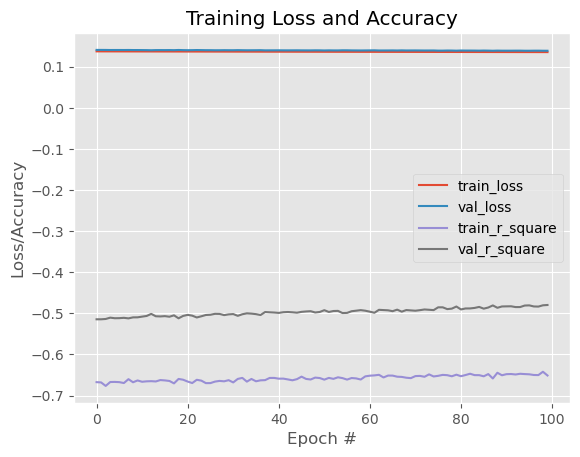

In [84]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["coeff_determination"], label="train_r_square")
plt.plot(np.arange(0, epochs),
         H.history["val_coeff_determination"], label="val_r_square")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()